<a href="https://colab.research.google.com/github/LoPA607/SOC-2024/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

In [ ]:
#for double convlutional layer
def double_conv(in_c, out_c):
  conv=nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True),
  )
  return conv

In [ ]:
def crop_img(tensor, target_tensor):
  target_size=target_tensor.size()[2]
  tensor_size=tensor.size()[2]
  delta=tensor_size-target_size
  delta=delta // 2
  return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

In [ ]:
class UNet(nn.Module):
  def __init__(self, in_channels=1, out_channels=1):
    super(UNet, self).__init__()
    self.max_pool_2x2=nn.MaxPool2d(kernel_size=2, stride=2)
    self.down_conv_1=double_conv(1,64)   #input=1channel and output=64channels
    self.down_conv_2=double_conv(64,128)
    self.down_conv_3=double_conv(128,256)
    self.down_conv_4=double_conv(256,512)
    self.down_conv_5=double_conv(512,1024)

    self.up_trans_1=nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
    self.up_conv_1=double_conv(1024, 512)

    self.up_trans_2=nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
    self.up_conv_2=double_conv(512, 256)

    self.up_trans_3=nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.up_conv_3=double_conv(256, 128)

    self.up_trans_4=nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.up_conv_4=double_conv(128, 64)

    self.out=nn.Conv2d(64, out_channels, kernel_size=1)


  def forward(self, image):
    #encoder
    x1=self.down_conv_1(image) #
    print(x1.size())
    x2=self.max_pool_2x2(x1)
    x3=self.down_conv_2(x2) #
    x4=self.max_pool_2x2(x3)
    x5=self.down_conv_3(x4) #
    x6=self.max_pool_2x2(x5)
    x7=self.down_conv_4(x6) #
    x8=self.max_pool_2x2(x7)
    x9=self.down_conv_5(x8)

    #decoder
    x = self.up_trans_1(x9)
    y = crop_img(x7,x)
    x=self.up_conv_1(torch.cat([x, y], 1))

    x = self.up_trans_2(x)
    y = crop_img(x5,x)
    x=self.up_conv_2(torch.cat([x, y], 1))

    x = self.up_trans_3(x)
    y = crop_img(x3,x)
    x=self.up_conv_3(torch.cat([x, y], 1))

    x = self.up_trans_4(x)
    y = crop_img(x1,x)
    x=self.up_conv_4(torch.cat([x, y], 1))

    x=self.out(x)
    return x





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/unet_imp/data

/content/drive/My Drive/unet_imp/data


In [ ]:
!mkdir training_images
!mkdir annotated_training_images

In [ ]:
import shutil
import os
%cd /content/drive/My Drive/unet_imp/data/training_set/training_set
for i in os.listdir():
  if i.endswith('.jpg') or i.endswith('.png'):
    if 'Annotation' in i:
      shutil.copy(i, '/content/drive/My Drive/unet_imp/data/annotated_training_images')
    else:
      shutil.copy(i, '/content/drive/My Drive/unet_imp/data/training_images')


/content/drive/My Drive/unet_imp/data/training_set/training_set


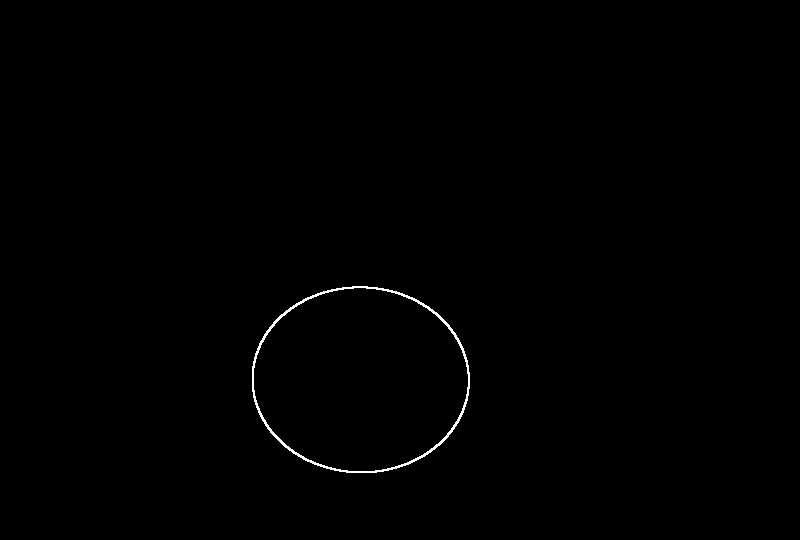

 <class 'numpy.ndarray'>


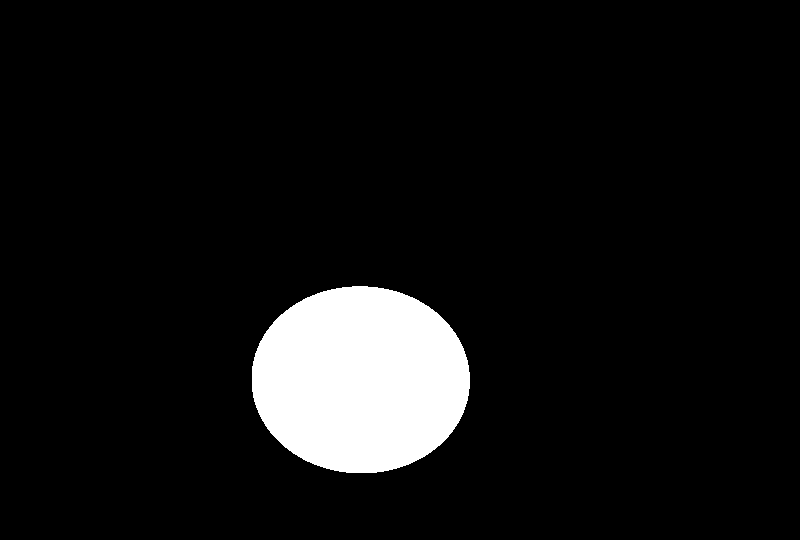

 <class 'numpy.ndarray'>


In [ ]:
#Masking
from google.colab.patches import cv2_imshow
import cv2
mask1 = cv2.imread(os.path.join('/content/drive/My Drive/unet_imp/data/annotated_training_images/100_2HC_Annotation.png'),0)
mask = cv2.imread(os.path.join('/content/drive/My Drive/unet_imp/data/annotated_training_images/100_2HC_Annotation.png'),0)
mask_contour= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_img = cv2.drawContours(mask,mask_contour[0],0,255, -1)
cv2_imshow(mask1)
print("" , type(mask1))
cv2_imshow(mask_img)
print("" , type(mask_img))


In [ ]:
import numpy as np
from PIL import Image
from torchvision.io import read_image
import torch
import matplotlib.pyplot as plt

torch.Size([1, 812, 812])


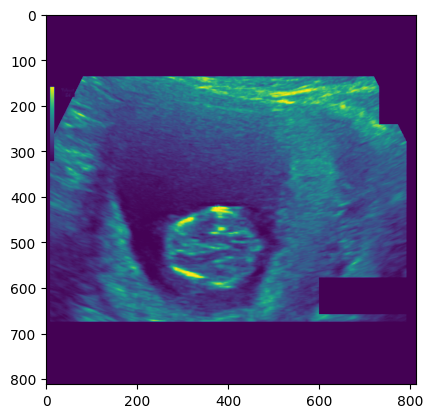

In [ ]:
def pad_image(img):
  channels,height,width=img.size()
  j=abs(812-width)
  padding=j // 2

  img=torch.nn.functional.pad(img,(padding,j-padding,0,0), mode='constant', value=0)
  channels,height,width=img.size()
  j=abs(height-width)
  padding=j // 2

  if height<width:
    padded_image=torch.nn.functional.pad(img,(0,0,padding,j-padding), mode='constant', value=0)
  else:
    padded_image=torch.nn.functional.pad(img,(padding,j-padding,0,0), mode='constant', value=0)
  return padded_image

img = read_image(os.path.join('/content/drive/My Drive/unet_imp/data/training_images/100_2HC.png'))

padded_img = pad_image(img)
print(padded_img.shape)

image = padded_img.permute(1, 2, 0)
plt.imshow(image)
plt.show()


In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import pandas as pd
from torchvision.io import read_image


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform , target_transform):
        self.img_path = img_path
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img = pad_image(img)

        if self.target_path:
          img_path_tar = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])

          target = cv2.imread(img_path_tar , 0)
          mask_contour= cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cv2.drawContours(target,mask_contour[0],0,255, -1)
          target = target[np.newaxis, :, :]
          target = torch.from_numpy(target)
          target = pad_image(target)
        else :
          target = torch.tensor([])


        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            target = self.target_transform(target)
            target = torch.where(target > 128, torch.tensor([1.0]), torch.tensor([0.0]))

        return img.float(), target.float()




transform = transforms.Compose([
    transforms.Resize((252, 252))
])

transform1 = transforms.Compose([
    transforms.Resize((68, 68))

])

dataset = CustomDataset(

    img_path ='/content/drive/My Drive/unet_imp/data/training_images',
    target_path ='/content/drive/My Drive/unet_imp/data/annotated_training_images/' ,
    transform=transform ,
    target_transform = transform1 )

test_dataset = CustomDataset(
    img_path ='/content/drive/My Drive/unet_imp/data/test_set/test_set' ,
    target_path = None ,
    transform=transform ,
    target_transform = None
    )

# justto check number of images
img_path ='/content/drive/My Drive/unet_imp/data/training_images/'
print(len(os.listdir(img_path)))
target_path ='/content/drive/My Drive/unet_imp/data/annotated_training_images/'
print(len(os.listdir(target_path)))


import torch.utils.data as data
train_dataset, val_dataset = data.random_split(dataset, [799, 200])


# Create train and validation dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)



999
999


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
torch.cuda.empty_cache()
import gc
gc.collect()

lr=0.001
epochs=10

model = UNet(in_channels=1,out_channels=1)
if torch.cuda.is_available():
  model.cuda()


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

v_loss , train_loss = [] , []

for epoch in range(epochs):
  model.train()
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = 0
    for inputs, targets in val_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        val_loss += criterion(outputs, targets)
    val_loss /= len(val_dataloader)
  v_loss.append(val_loss.item())
  train_loss.append(loss.item())
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}  , Val Loss: {val_loss.item():.4f}")

torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Size([16, 64, 248, 248])
torch.Si